## 1. Setup and Dependencies

In [1]:
!pip install -q torch transformers datasets matplotlib numpy tqdm scikit-learn pandas accelerate

In [2]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
import pandas as pd
import re
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
    DataCollatorForLanguageModeling
)

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Print GPU info if available
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0) / 1024**2:.2f} MB")
    print(f"Memory Reserved: {torch.cuda.memory_reserved(0) / 1024**2:.2f} MB")
    
    # Set CUDA debugging flags
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # For better error reporting

Using device: cuda
GPU: Tesla P100-PCIE-16GB
CUDA Version: 12.1
Memory Allocated: 0.00 MB
Memory Reserved: 0.00 MB


## 2. Dataset Creation from Multiple Projects

We'll use three popular GitHub repositories to create a diverse dataset:
1. Python-World/python-mini-projects: Collection of small Python projects
2. scikit-learn/scikit-learn: Machine learning library in Python
3. django/django: High-level Python web framework

In [3]:
# Define repositories to clone
repositories = [
    {
        "name": "python-mini-projects",
        "url": "https://github.com/Python-World/python-mini-projects.git",
        "code_dir": "projects",  
        "depth": 1 
    },
    {
        "name": "scikit-learn",
        "url": "https://github.com/scikit-learn/scikit-learn.git",
        "code_dir": "sklearn", 
        "depth": 1  
    },
    {
        "name": "django",
        "url": "https://github.com/django/django.git",
        "code_dir": "django",  
        "depth": 1 
    }
]

In [4]:
# Clone repositories
for repo in repositories:
    if not os.path.exists(repo["name"]):
        !git clone --depth={repo["depth"]} {repo["url"]} {repo["name"]}
        print(f"Repository {repo['name']} cloned successfully!")
    else:
        print(f"Repository {repo['name']} already exists.")

Cloning into 'python-mini-projects'...
remote: Enumerating objects: 936, done.
remote: Counting objects: 100% (936/936), done.
remote: Compressing objects: 100% (853/853), done.
remote: Total 936 (delta 18), reused 818 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (936/936), 48.05 MiB | 45.77 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Repository python-mini-projects cloned successfully!
Cloning into 'scikit-learn'...
remote: Enumerating objects: 1830, done.
remote: Counting objects: 100% (1830/1830), done.
remote: Compressing objects: 100% (1763/1763), done.
remote: Total 1830 (delta 69), reused 621 (delta 46), pack-reused 0 (from 0)
Receiving objects: 100% (1830/1830), 7.51 MiB | 14.42 MiB/s, done.
Resolving deltas: 100% (69/69), done.
Repository scikit-learn cloned successfully!
Cloning into 'django'...
remote: Enumerating objects: 9353, done.
remote: Counting objects: 100% (9353/9353), done.
remote: Compressing objects: 100% (5862/5862), done.
remote: Total 9353

In [5]:
# Define paths
DATASET_PATH = 'code_dataset'

# Create dataset directories
os.makedirs(os.path.join(DATASET_PATH, 'train'), exist_ok=True)
os.makedirs(os.path.join(DATASET_PATH, 'val'), exist_ok=True)
os.makedirs(os.path.join(DATASET_PATH, 'test'), exist_ok=True)

## 3. Long Context Preparation

To align with the Long Code Arena benchmarks, we need to prepare our dataset with a focus on long context understanding. We'll extract not just individual files but also project-level context.

In [6]:
# Function to extract Python files and project context from a repository
def extract_project_files(repo_name, code_dir):
    repo_path = os.path.join(repo_name, code_dir)
    python_files = []
    project_structure = []
    imports_map = {}
    class_definitions = {}
    function_definitions = {}
    
    # Walk through the repository
    for root, dirs, files in os.walk(repo_path):
        rel_path = os.path.relpath(root, repo_path)
        if rel_path == '.':
            rel_path = ''
        
        # Record directory structure
        if rel_path:
            project_structure.append(f"dir: {rel_path}")
        
        for file in files:
            if file.endswith('.py'):
                file_path = os.path.join(root, file)
                file_rel_path = os.path.join(rel_path, file) if rel_path else file
                
                try:
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                        content = f.read()
                        
                        # Skip empty files or very small files
                        if len(content.strip()) > 50:  # Minimum content length
                            # Record file in project structure
                            project_structure.append(f"file: {file_rel_path}")
                            
                            # Extract imports
                            import_lines = [line for line in content.split('\n') if re.match(r'^\s*(import|from)\s+', line)]
                            if import_lines:
                                imports_map[file_rel_path] = import_lines
                            
                            # Extract class definitions
                            class_matches = re.finditer(r'^\s*class\s+(\w+)\s*(?:\(([^)]+)\))?\s*:', content, re.MULTILINE)
                            classes = []
                            for match in class_matches:
                                class_name = match.group(1)
                                parent_class = match.group(2) if match.group(2) else ''
                                classes.append((class_name, parent_class))
                            
                            if classes:
                                class_definitions[file_rel_path] = classes
                            
                            # Extract function definitions
                            func_matches = re.finditer(r'^\s*def\s+(\w+)\s*\(([^)]*)\)\s*(?:->\s*([^:]+))?\s*:', content, re.MULTILINE)
                            functions = []
                            for match in func_matches:
                                func_name = match.group(1)
                                params = match.group(2) if match.group(2) else ''
                                return_type = match.group(3) if match.group(3) else ''
                                functions.append((func_name, params, return_type))
                            
                            if functions:
                                function_definitions[file_rel_path] = functions
                            
                            # Add file to the list
                            python_files.append({
                                'path': file_path,
                                'rel_path': file_rel_path,
                                'content': content,
                                'repo': repo_name
                            })
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
    
    # Create project context
    project_context = {
        'name': repo_name,
        'structure': project_structure,
        'imports': imports_map,
        'classes': class_definitions,
        'functions': function_definitions
    }
    
    return python_files, project_context

In [7]:
# Extract files and project context from all repositories
all_python_files = []
project_contexts = {}

for repo in repositories:
    print(f"Extracting Python files and project context from {repo['name']}...")
    repo_files, repo_context = extract_project_files(repo['name'], repo['code_dir'])
    all_python_files.extend(repo_files)
    project_contexts[repo['name']] = repo_context
    print(f"Found {len(repo_files)} Python files in {repo['name']}")

print(f"Total Python files collected: {len(all_python_files)}")

# Save project contexts
os.makedirs(os.path.join(DATASET_PATH, 'project_contexts'), exist_ok=True)
for repo_name, context in project_contexts.items():
    with open(os.path.join(DATASET_PATH, 'project_contexts', f"{repo_name}_context.json"), 'w', encoding='utf-8') as f:
        json.dump(context, f, indent=2)

Extracting Python files and project context from python-mini-projects...
Found 156 Python files in python-mini-projects
Extracting Python files and project context from scikit-learn...
Found 554 Python files in scikit-learn
Extracting Python files and project context from django...
Found 734 Python files in django
Total Python files collected: 1444


In [8]:
# Split files into train, validation, and test sets
train_files, test_files = train_test_split(all_python_files, test_size=0.2, random_state=SEED)
val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=SEED)

print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

Train files: 1155
Validation files: 144
Test files: 145


In [9]:
def save_files_to_dataset(files, split):
    output_dir = os.path.join(DATASET_PATH, split)
    file_info = []
    
    for i, file_data in enumerate(files):
        # Create a unique filename
        repo_name = file_data['repo']
        file_rel_path = file_data['rel_path']
        file_name = f"{repo_name}_{i}_{file_rel_path.replace('/', '_')}"
        output_path = os.path.join(output_dir, file_name)
        
        # Save the file
        with open(output_path, 'w', encoding='utf-8') as f:
            f.write(file_data['content'])
        
        # Create a context file
        context_file_name = f"{file_name}_context.json"
        context_output_path = os.path.join(output_dir, context_file_name)
        
        # Extract relevant context for this file
        repo_context = project_contexts[repo_name]
        file_context = {
            'repo': repo_name,
            'file_path': file_rel_path,
            'imports': repo_context['imports'].get(file_rel_path, []),
            'classes': repo_context['classes'].get(file_rel_path, []),
            'functions': repo_context['functions'].get(file_rel_path, []),
            # Add related files (files in the same directory or imported)
            'related_files': [f for f in repo_context['structure'] if f.startswith(f"file: {os.path.dirname(file_rel_path)}")]
        }
        
        # Save the context file
        with open(context_output_path, 'w', encoding='utf-8') as f:
            json.dump(file_context, f, indent=2)
        
        # Record file information
        file_info.append({
            'original_path': file_data['path'],
            'rel_path': file_rel_path,
            'dataset_path': output_path,
            'context_path': context_output_path,
            'repo': repo_name,
            'size': len(file_data['content'])
        })
    
    # Save metadata
    metadata_path = os.path.join(output_dir, 'metadata.json')
    with open(metadata_path, 'w', encoding='utf-8') as f:
        json.dump({
            'count': len(files),
            'files': file_info
        }, f, indent=2)
    
    return file_info

In [10]:
# Save files to dataset directories
print("Saving train files...")
train_info = save_files_to_dataset(train_files, 'train')
print("Saving validation files...")
val_info = save_files_to_dataset(val_files, 'val')
print("Saving test files...")
test_info = save_files_to_dataset(test_files, 'test')

# Save overall dataset metadata
dataset_metadata = {
    'repositories': [repo['name'] for repo in repositories],
    'train_size': len(train_files),
    'val_size': len(val_files),
    'test_size': len(test_files),
    'total_size': len(all_python_files)
}

with open(os.path.join(DATASET_PATH, 'dataset_info.json'), 'w', encoding='utf-8') as f:
    json.dump(dataset_metadata, f, indent=2)

print("Dataset creation completed!")

Saving train files...
Saving validation files...
Saving test files...
Dataset creation completed!


## 4. Implementing Long Code Arena Benchmarks

Based on the Long Code Arena paper, we'll implement the following benchmarks:

1. **Library-based code generation**: Generate code based on instructions and library context
2. **Project-level code completion**: Complete code with project-wide context

In [11]:
# Create benchmark datasets directory
BENCHMARKS_PATH = 'lca_benchmarks'
os.makedirs(BENCHMARKS_PATH, exist_ok=True)

### 4.1 Library-based Code Generation Benchmark

In [12]:
def create_library_based_code_generation_benchmark():
    benchmark_dir = os.path.join(BENCHMARKS_PATH, 'library_based_code_generation')
    os.makedirs(benchmark_dir, exist_ok=True)
    
    # Create benchmark examples
    examples = []
    
    # For each repository
    for repo_name, context in project_contexts.items():
        # Get all class and function definitions
        all_classes = []
        for file_path, classes in context['classes'].items():
            for class_name, parent_class in classes:
                all_classes.append({
                    'name': class_name,
                    'parent': parent_class,
                    'file': file_path
                })
        
        all_functions = []
        for file_path, functions in context['functions'].items():
            for func_name, params, return_type in functions:
                all_functions.append({
                    'name': func_name,
                    'params': params,
                    'return_type': return_type,
                    'file': file_path
                })
        
        # Create instructions for code generation
        if repo_name == 'python-mini-projects':
            instructions = [
                "Create a function to download images from a URL",
                "Write a program to convert JSON to CSV",
                "Implement a binary search algorithm",
                "Create a function to check if a string is a palindrome",
                "Write a program to extract text from a PDF file"
            ]
        elif repo_name == 'scikit-learn':
            instructions = [
                "Implement a function to calculate the accuracy score",
                "Create a class for K-means clustering",
                "Write a function to split data into training and testing sets",
                "Implement a function to calculate the mean squared error",
                "Create a class for a decision tree classifier"
            ]
        elif repo_name == 'django':
            instructions = [
                "Create a function to handle HTTP requests",
                "Implement a class for form validation",
                "Write a function to render a template",
                "Create a middleware class for authentication",
                "Implement a function to handle URL routing"
            ]
        
        # Create examples
        for instruction in instructions:
            relevant_classes = random.sample(all_classes, min(20, len(all_classes)))
            relevant_functions = random.sample(all_functions, min(20, len(all_functions)))
            
            # Create example
            example = {
                'instruction': instruction,
                'repository': repo_name,
                'relevant_classes': relevant_classes,
                'relevant_functions': relevant_functions
            }
            
            examples.append(example)
    
    # Save benchmark examples
    with open(os.path.join(benchmark_dir, 'examples.json'), 'w', encoding='utf-8') as f:
        json.dump(examples, f, indent=2)
    
    print(f"Created {len(examples)} examples for library-based code generation benchmark")
    return examples

# Create library-based code generation benchmark
library_based_examples = create_library_based_code_generation_benchmark()

Created 15 examples for library-based code generation benchmark


### 4.2 Project-level Code Completion Benchmark

In [13]:
def create_project_level_code_completion_benchmark():
    benchmark_dir = os.path.join(BENCHMARKS_PATH, 'project_level_code_completion')
    os.makedirs(benchmark_dir, exist_ok=True)
    
    # Create benchmark examples
    examples = []
    
    # Use test files for the benchmark
    for file_data in test_files:
        content = file_data['content']
        lines = content.split('\n')
        
        # Skip files with too few lines
        if len(lines) < 10:
            continue
        
        # Find function or method definitions
        func_line_indices = [i for i, line in enumerate(lines) if re.match(r'^\s*def\s+\w+\s*\(', line)]
        
        # Skip files with no functions
        if not func_line_indices:
            continue
        
        # Select a random function
        func_line_idx = random.choice(func_line_indices)
        
        # Find the function body
        body_start = func_line_idx + 1
        body_end = body_start
        indent_level = len(lines[body_start]) - len(lines[body_start].lstrip())
        
        while body_end < len(lines) and (not lines[body_end].strip() or len(lines[body_end]) - len(lines[body_end].lstrip()) > indent_level):
            body_end += 1
        
        # Skip functions with too small bodies
        if body_end - body_start < 5:
            continue
        
        # Select a random line to complete
        completion_line_idx = random.randint(body_start + 2, body_end - 2)
        
        # Create the example
        prefix = '\n'.join(lines[:completion_line_idx])
        target = lines[completion_line_idx]
        suffix = '\n'.join(lines[completion_line_idx+1:])
        
        # Get project context
        repo_name = file_data['repo']
        file_rel_path = file_data['rel_path']
        
        # Create example
        example = {
            'repository': repo_name,
            'file_path': file_rel_path,
            'prefix': prefix,
            'target': target,
            'suffix': suffix,
            'line_number': completion_line_idx + 1  # 1-indexed
        }
        
        examples.append(example)
        
        # Limit to 50 examples
        if len(examples) >= 50:
            break
    
    # Save benchmark examples
    with open(os.path.join(benchmark_dir, 'examples.json'), 'w', encoding='utf-8') as f:
        json.dump(examples, f, indent=2)
    
    print(f"Created {len(examples)} examples for project-level code completion benchmark")
    return examples

# Create project-level code completion benchmark
code_completion_examples = create_project_level_code_completion_benchmark()

Created 0 examples for project-level code completion benchmark


## 5. Dataset Class with Long Context Focus

In [14]:
class LongContextCodeDataset(Dataset):
    def __init__(self, data_dir, tokenizer, max_length=1024, context_length=768, use_project_context=True):
        self.data_dir = data_dir
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.context_length = context_length
        self.use_project_context = use_project_context
        self.examples = []
        self.valid_indices = []
        
        # Load Python files
        python_files = [f for f in os.listdir(data_dir) if f.endswith('.py')]
        
        # Process each Python file
        for file_name in python_files:
            file_path = os.path.join(data_dir, file_name)
            context_file_path = os.path.join(data_dir, f"{file_name}_context.json")
            
            # Skip if context file doesn't exist
            if not os.path.exists(context_file_path) and self.use_project_context:
                continue
            
            try:
                # Read file content
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    content = f.read()
                    
                    # Skip empty files
                    if not content.strip():
                        continue
                
                # Read context if available and requested
                context = None
                if self.use_project_context and os.path.exists(context_file_path):
                    with open(context_file_path, 'r', encoding='utf-8') as f:
                        context = json.load(f)
                
                # Add to examples
                self.examples.append({
                    'content': content,
                    'file_name': file_name,
                    'context': context
                })
                
                # Pre-validate this example
                try:
                    # Try tokenizing to catch any issues early
                    text = self._prepare_text(self.examples[-1])
                    encodings = self._tokenize_text(text)
                    if encodings is not None:
                        self.valid_indices.append(len(self.examples) - 1)
                except Exception as e:
                    print(f"Skipping example {file_name} due to tokenization error: {e}")
                    
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
        
        print(f"Loaded {len(self.valid_indices)} valid examples out of {len(self.examples)} total")
    
    def __len__(self):
        return len(self.valid_indices)
    
    def get_project_context_string(self, context):
        """Convert project context to a string representation"""
        if not context:
            return ""
        
        context_parts = []
        
        # Add repository and file path
        context_parts.append(f"Repository: {context['repo']}")
        context_parts.append(f"File: {context['file_path']}")
        
        # Add imports
        if context['imports']:
            context_parts.append("\nImports:")
            for imp in context['imports']:
                context_parts.append(imp)
        
        # Add classes
        if context['classes']:
            context_parts.append("\nClasses:")
            for class_name, parent_class in context['classes']:
                if parent_class:
                    context_parts.append(f"class {class_name}({parent_class}):")
                else:
                    context_parts.append(f"class {class_name}:")
        
        # Add functions
        if context['functions']:
            context_parts.append("\nFunctions:")
            for func_name, params, return_type in context['functions']:
                if return_type:
                    context_parts.append(f"def {func_name}({params}) -> {return_type}:")
                else:
                    context_parts.append(f"def {func_name}({params}):")
        
        # Add related files
        if context['related_files']:
            context_parts.append("\nRelated Files:")
            for file in context['related_files']:
                context_parts.append(file)
        
        return "\n".join(context_parts)
    
    def _prepare_text(self, example):
        """Prepare text with context if available"""
        content = example['content']
        
        # Add project context if available and requested
        if self.use_project_context and example['context']:
            context_str = self.get_project_context_string(example['context'])
            
            # Limit context length
            context_tokens = self.tokenizer.encode(context_str, add_special_tokens=False)
            if len(context_tokens) > self.context_length:
                context_tokens = context_tokens[:self.context_length]
                context_str = self.tokenizer.decode(context_tokens)
            
            # Combine context and content
            text = f"{context_str}\n\n{content}"
        else:
            text = content
            
        return text
    
    def _tokenize_text(self, text):
        """Tokenize text with error handling"""
        try:
            encodings = self.tokenizer(
                text,
                truncation=True,
                max_length=self.max_length,
                padding="max_length",
                return_tensors="pt"
            )
            return encodings
        except Exception as e:
            print(f"Tokenization error: {e}")
            return None
    
    def __getitem__(self, idx):
        # Get the actual example index from valid indices
        example_idx = self.valid_indices[idx]
        example = self.examples[example_idx]
        
        try:
            # Prepare text
            text = self._prepare_text(example)
            
            # Tokenize
            encodings = self._tokenize_text(text)
            if encodings is None:
                raise ValueError(f"Failed to tokenize example {example['file_name']}")
            
            # Create input_ids and labels for causal language modeling
            input_ids = encodings.input_ids[0]
            attention_mask = encodings.attention_mask[0]
            
            # Verify tensor shapes and values
            if torch.any(torch.isnan(input_ids)) or torch.any(torch.isnan(attention_mask)):
                raise ValueError(f"NaN values detected in tensors for example {example['file_name']}")
                
            if input_ids.shape[0] != self.max_length or attention_mask.shape[0] != self.max_length:
                raise ValueError(f"Incorrect tensor shapes for example {example['file_name']}")
            
            # Create labels (same as input_ids for causal LM)
            labels = input_ids.clone()
            
            return {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels": labels
            }
        except Exception as e:
            print(f"Error processing example {example['file_name']} at index {idx}: {e}")
            return 0

## 6. Advanced Model Preparation

Let's load the pre-trained model and prepare it for fine-tuning with a focus on long context understanding.

In [15]:
# Configuration
MODEL_NAME = "distilgpt2"
OUTPUT_DIR = "/kaggle/fine_tuned_model"
MAX_LENGTH = 512  # Reduced for better compatibility
CONTEXT_LENGTH = 384  # Length allocated for project context
BATCH_SIZE = 2  # Reduced for better compatibility
LEARNING_RATE = 5e-5
NUM_EPOCHS = 30
WARMUP_RATIO = 0.1  # Percentage of steps for warmup
WEIGHT_DECAY = 0.01
LOGGING_STEPS = 100
SAVE_STEPS = 500
EVAL_STEPS = 500
USE_PROJECT_CONTEXT = True  # Enable project context

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [16]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)

# Fix the padding token issue
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print(f"Set padding token to: {tokenizer.pad_token}")

# Special tokens for Python code
special_tokens = {
    "additional_special_tokens": [
        "def", "class", "if", "else", "for", "while", "import", "from", "return",
        "try", "except", "finally", "with", "as", "lambda", "yield", "raise",
        "async", "await", "break", "continue", "global", "nonlocal", "pass",
        "assert", "del", "elif", "in", "is", "not", "or", "and"
    ]
}

# Add special tokens
num_added_tokens = tokenizer.add_special_tokens(special_tokens)
print(f"Added {num_added_tokens} special tokens to the tokenizer")
model.resize_token_embeddings(len(tokenizer))

model.to(device)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Set padding token to: <|endoftext|>
Added 32 special tokens to the tokenizer


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50263, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50263, bias=False)
)

In [17]:
# Create datasets with long context focus
train_dataset = LongContextCodeDataset(
    os.path.join(DATASET_PATH, "train"), 
    tokenizer, 
    max_length=MAX_LENGTH,
    context_length=CONTEXT_LENGTH,
    use_project_context=USE_PROJECT_CONTEXT
)

val_dataset = LongContextCodeDataset(
    os.path.join(DATASET_PATH, "val"), 
    tokenizer, 
    max_length=MAX_LENGTH,
    context_length=CONTEXT_LENGTH,
    use_project_context=USE_PROJECT_CONTEXT
)

test_dataset = LongContextCodeDataset(
    os.path.join(DATASET_PATH, "test"), 
    tokenizer, 
    max_length=MAX_LENGTH,
    context_length=CONTEXT_LENGTH,
    use_project_context=USE_PROJECT_CONTEXT
)

print(f"Train examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")
print(f"Test examples: {len(test_dataset)}")

Token indices sequence length is longer than the specified maximum sequence length for this model (2262 > 1024). Running this sequence through the model will result in indexing errors


Loaded 1155 valid examples out of 1155 total
Loaded 144 valid examples out of 144 total
Loaded 145 valid examples out of 145 total
Train examples: 1155
Validation examples: 144
Test examples: 145


In [18]:
# Verify dataset integrity by checking a few examples
def verify_dataset(dataset, name):
    print(f"Verifying {name} dataset...")
    for i in range(min(5, len(dataset))):
        try:
            sample = dataset[i]
            input_ids = sample["input_ids"]
            attention_mask = sample["attention_mask"]
            labels = sample["labels"]
            
            # Check shapes
            assert input_ids.shape[0] == MAX_LENGTH, f"Input ids shape mismatch: {input_ids.shape}"
            assert attention_mask.shape[0] == MAX_LENGTH, f"Attention mask shape mismatch: {attention_mask.shape}"
            assert labels.shape[0] == MAX_LENGTH, f"Labels shape mismatch: {labels.shape}"
            
            # Check for NaN values
            assert not torch.isnan(input_ids).any(), "NaN values in input_ids"
            assert not torch.isnan(attention_mask).any(), "NaN values in attention_mask"
            assert not torch.isnan(labels).any(), "NaN values in labels"
            
            # Check for invalid indices
            assert (input_ids >= 0).all() and (input_ids < len(tokenizer)).all(), "Invalid token indices in input_ids"
            assert (labels >= 0).all() and (labels < len(tokenizer)).all(), "Invalid token indices in labels"
            
            # Check attention mask values
            assert ((attention_mask == 0) | (attention_mask == 1)).all(), "Invalid values in attention_mask"
            
            print(f"  Sample {i} verified successfully")
        except Exception as e:
            print(f"  Error verifying sample {i}: {e}")
    print(f"{name} dataset verification completed")

# Verify all datasets
verify_dataset(train_dataset, "Train")
verify_dataset(val_dataset, "Validation")
verify_dataset(test_dataset, "Test")

Verifying Train dataset...
  Sample 0 verified successfully
  Sample 1 verified successfully
  Sample 2 verified successfully
  Sample 3 verified successfully
  Sample 4 verified successfully
Train dataset verification completed
Verifying Validation dataset...
  Sample 0 verified successfully
  Sample 1 verified successfully
  Sample 2 verified successfully
  Sample 3 verified successfully
  Sample 4 verified successfully
Validation dataset verification completed
Verifying Test dataset...
  Sample 0 verified successfully
  Sample 1 verified successfully
  Sample 2 verified successfully
  Sample 3 verified successfully
  Sample 4 verified successfully
Test dataset verification completed


In [19]:
# Create a custom collator that handles errors
class SafeDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.mlm = False
        self.mlm_probability = 0.15
        
    def __call__(self, examples):
        try:
            # Check if examples is empty
            if not examples:
                raise ValueError("Empty batch received")
            
            # Extract tensors
            input_ids = [example["input_ids"] for example in examples]
            attention_mask = [example["attention_mask"] for example in examples]
            labels = [example["labels"] for example in examples]
            
            # Verify all tensors have the same shape
            input_shape = input_ids[0].shape
            for i, tensor in enumerate(input_ids):
                if tensor.shape != input_shape:
                    print(f"Shape mismatch in input_ids at index {i}: {tensor.shape} vs {input_shape}")
                    # Fix the shape
                    if tensor.shape[0] < input_shape[0]:
                        # Pad
                        padding = torch.full((input_shape[0] - tensor.shape[0],), self.tokenizer.pad_token_id, dtype=torch.long)
                        input_ids[i] = torch.cat([tensor, padding])
                    else:
                        # Truncate
                        input_ids[i] = tensor[:input_shape[0]]
            
            # Do the same for attention_mask and labels
            for i, tensor in enumerate(attention_mask):
                if tensor.shape != input_shape:
                    if tensor.shape[0] < input_shape[0]:
                        padding = torch.zeros(input_shape[0] - tensor.shape[0], dtype=torch.long)
                        attention_mask[i] = torch.cat([tensor, padding])
                    else:
                        attention_mask[i] = tensor[:input_shape[0]]
            
            for i, tensor in enumerate(labels):
                if tensor.shape != input_shape:
                    if tensor.shape[0] < input_shape[0]:
                        padding = torch.full((input_shape[0] - tensor.shape[0],), -100, dtype=torch.long)
                        labels[i] = torch.cat([tensor, padding])
                    else:
                        labels[i] = tensor[:input_shape[0]]
            
            # Stack tensors
            batch = {
                "input_ids": torch.stack(input_ids),
                "attention_mask": torch.stack(attention_mask),
                "labels": torch.stack(labels)
            }
            
            # Final verification
            for key, tensor in batch.items():
                if torch.isnan(tensor).any():
                    raise ValueError(f"NaN values detected in {key}")
                if key == "input_ids" or key == "labels":
                    if (tensor < 0).any() and key != "labels":
                        raise ValueError(f"Negative values detected in {key}")
                    if (tensor >= len(self.tokenizer)).any():
                        raise ValueError(f"Token indices out of range in {key}")
            
            return batch
        except Exception as e:
            print(f"Error in collator: {e}")
            return 0

# Create data collator
data_collator = SafeDataCollator(tokenizer)

# Create dataloaders with error handling
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=data_collator,
    num_workers=4,  # Use single-process loading for stability
    pin_memory=True if torch.cuda.is_available() else False
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
    num_workers=4,  # Use single-process loading for stability
    pin_memory=True if torch.cuda.is_available() else False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
    num_workers=4,  # Use single-process loading for stability
    pin_memory=True if torch.cuda.is_available() else False
)

## 7. Fine-tuning Process with Long Context Focus

Training and evaluation functions with a focus on long context understanding and error handling.

In [20]:
def train_epoch(model, dataloader, optimizer, scheduler, device, gradient_accumulation_steps=1):
    model.train()
    total_loss = 0
    step_loss = 0
    steps = 0
    log_steps = 0
    losses = []
    
    # Implement gradient accumulation for larger effective batch size
    optimizer.zero_grad()
    
    progress_bar = tqdm(dataloader, desc="Training")
    for batch_idx, batch in enumerate(progress_bar):
        try:
            # Move batch to device with error handling
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Verify tensor shapes and values before forward pass
            for key, tensor in batch.items():
                if torch.isnan(tensor).any():
                    raise ValueError(f"NaN values detected in {key}")
                
                # Check for out-of-range indices in input_ids
                if key == "input_ids" and ((tensor < 0).any() or (tensor >= len(tokenizer)).any()):
                    # Fix out-of-range indices
                    tensor = torch.clamp(tensor, 0, len(tokenizer) - 1)
                    batch[key] = tensor
            
            # Forward pass with error handling
            try:
                outputs = model(**batch)
                loss = outputs.loss
                
                # Check for NaN loss
                if torch.isnan(loss).any():
                    raise ValueError("NaN loss detected")
                
                # Scale loss for gradient accumulation
                loss = loss / gradient_accumulation_steps
                
                # Backward pass
                loss.backward()
            except RuntimeError as e:
                if "CUDA error" in str(e):
                    print(f"CUDA error in batch {batch_idx}: {e}")
                    # Skip this batch and continue
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e
            
            # Update weights every gradient_accumulation_steps
            if (batch_idx + 1) % gradient_accumulation_steps == 0:
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
            
            # Track loss (use the unscaled loss for reporting)
            batch_loss = loss.item() * gradient_accumulation_steps
            total_loss += batch_loss
            step_loss += batch_loss
            steps += 1
            log_steps += 1
            
            # Update progress bar
            progress_bar.set_postfix({"loss": batch_loss})
            
            # Log progress
            if log_steps % LOGGING_STEPS == 0:
                avg_step_loss = step_loss / log_steps
                losses.append({"step": steps, "loss": avg_step_loss})
                step_loss = 0
                log_steps = 0
        except Exception as e:
            print(f"Error in training batch {batch_idx}: {e}")
            # Skip this batch and continue
            continue
    
    # Handle any remaining gradients
    if steps > 0 and (batch_idx + 1) % gradient_accumulation_steps != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    # Avoid division by zero
    if steps == 0:
        return 0.0, []
    
    return total_loss / steps, losses

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    steps = 0
    
    progress_bar = tqdm(dataloader, desc="Evaluating")
    with torch.no_grad():
        for batch in progress_bar:
            try:
                # Move batch to device with error handling
                batch = {k: v.to(device) for k, v in batch.items()}
                
                # Verify tensor shapes and values before forward pass
                for key, tensor in batch.items():
                    if torch.isnan(tensor).any():
                        raise ValueError(f"NaN values detected in {key}")
                    
                    # Check for out-of-range indices in input_ids
                    if key == "input_ids" and ((tensor < 0).any() or (tensor >= len(tokenizer)).any()):
                        # Fix out-of-range indices
                        tensor = torch.clamp(tensor, 0, len(tokenizer) - 1)
                        batch[key] = tensor
                
                # Forward pass with error handling
                try:
                    outputs = model(**batch)
                    loss = outputs.loss
                    
                    # Check for NaN loss
                    if torch.isnan(loss).any():
                        raise ValueError("NaN loss detected")
                except RuntimeError as e:
                    if "CUDA error" in str(e):
                        print(f"CUDA error in evaluation: {e}")
                        # Skip this batch and continue
                        torch.cuda.empty_cache()
                        continue
                    else:
                        raise e
                
                # Track loss
                total_loss += loss.item()
                steps += 1
                
                # Update progress bar
                progress_bar.set_postfix({"loss": loss.item()})
            except Exception as e:
                print(f"Error in evaluation batch: {e}")
                # Skip this batch and continue
                continue
    
    # Avoid division by zero
    if steps == 0:
        return 0.0
    
    return total_loss / steps

In [21]:
# Apply weight decay only to weight matrices, not to biases and LayerNorm
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": WEIGHT_DECAY,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE)

# Calculate total steps and warmup steps
total_steps = len(train_dataloader) * NUM_EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

# Use cosine scheduler with warmup for better convergence
scheduler = get_cosine_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=warmup_steps, 
    num_training_steps=total_steps
)

print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {warmup_steps}")

Total training steps: 17340
Warmup steps: 1734


## 8. Fine-tuning with Long Context Focus

In [22]:
# Execute fine-tuning
print("Starting fine-tuning...")

# Initialize tracking variables
history = {
    "train_loss": [],
    "eval_loss": [],
    "steps": [],
    "eval_steps": []
}

# Set gradient accumulation steps based on batch size
gradient_accumulation_steps = 4  # Effective batch size = BATCH_SIZE * gradient_accumulation_steps

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss, step_losses = train_epoch(
        model,
        train_dataloader,
        optimizer,
        scheduler,
        device,
        gradient_accumulation_steps
    )
    print(f"Epoch {epoch+1}: Average train loss = {train_loss:.4f}")
    
    # Evaluate
    eval_loss = evaluate(model, val_dataloader, device)
    print(f"Epoch {epoch+1}: Validation loss = {eval_loss:.4f}")
    
    # Update history
    for step_loss in step_losses:
        history["train_loss"].append(step_loss["loss"])
        history["steps"].append(step_loss["step"] + epoch * len(train_dataloader))
    
    history["eval_loss"].append(eval_loss)
    history["eval_steps"].append((epoch + 1) * len(train_dataloader))
    
    # Save checkpoint
    checkpoint_dir = os.path.join(OUTPUT_DIR, f"checkpoint-epoch-{epoch+1}")
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Save model and tokenizer
    model.save_pretrained(checkpoint_dir)
    tokenizer.save_pretrained(checkpoint_dir)
    
    # Save optimizer and scheduler
    torch.save(optimizer.state_dict(), os.path.join(checkpoint_dir, "optimizer.pt"))
    torch.save(scheduler.state_dict(), os.path.join(checkpoint_dir, "scheduler.pt"))
    
    # Save training history
    with open(os.path.join(OUTPUT_DIR, "training_history.json"), "w") as f:
        json.dump(history, f, indent=2)

print("Fine-tuning completed!")

Starting fine-tuning...

Epoch 1/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 1: Average train loss = 3.0891


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 1: Validation loss = 2.4648

Epoch 2/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 2: Average train loss = 2.2357


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 2: Validation loss = 1.8313

Epoch 3/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 3: Average train loss = 1.7875


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 3: Validation loss = 1.5653

Epoch 4/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 4: Average train loss = 1.5703


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 4: Validation loss = 1.4202

Epoch 5/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 5: Average train loss = 1.4388


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 5: Validation loss = 1.3116

Epoch 6/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 6: Average train loss = 1.3338


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 6: Validation loss = 1.2343

Epoch 7/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 7: Average train loss = 1.2492


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 7: Validation loss = 1.1654

Epoch 8/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 8: Average train loss = 1.1763


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 8: Validation loss = 1.1105

Epoch 9/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 9: Average train loss = 1.1120


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 9: Validation loss = 1.0644

Epoch 10/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 10: Average train loss = 1.0576


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 10: Validation loss = 1.0227

Epoch 11/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 11: Average train loss = 1.0032


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 11: Validation loss = 0.9999

Epoch 12/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 12: Average train loss = 0.9543


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 12: Validation loss = 0.9650

Epoch 13/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 13: Average train loss = 0.9068


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 13: Validation loss = 0.9425

Epoch 14/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 14: Average train loss = 0.8656


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 14: Validation loss = 0.9214

Epoch 15/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 15: Average train loss = 0.8256


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 15: Validation loss = 0.9020

Epoch 16/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 16: Average train loss = 0.7910


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 16: Validation loss = 0.8903

Epoch 17/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 17: Average train loss = 0.7592


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 17: Validation loss = 0.8917

Epoch 18/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 18: Average train loss = 0.7294


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 18: Validation loss = 0.8754

Epoch 19/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 19: Average train loss = 0.7006


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 19: Validation loss = 0.8622

Epoch 20/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 20: Average train loss = 0.6743


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 20: Validation loss = 0.8570

Epoch 21/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 21: Average train loss = 0.6508


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 21: Validation loss = 0.8574

Epoch 22/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 22: Average train loss = 0.6278


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 22: Validation loss = 0.8531

Epoch 23/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 23: Average train loss = 0.6066


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 23: Validation loss = 0.8543

Epoch 24/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 24: Average train loss = 0.5861


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 24: Validation loss = 0.8500

Epoch 25/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 25: Average train loss = 0.5664


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 25: Validation loss = 0.8491

Epoch 26/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 26: Average train loss = 0.5471


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 26: Validation loss = 0.8564

Epoch 27/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 27: Average train loss = 0.5287


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 27: Validation loss = 0.8581

Epoch 28/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 28: Average train loss = 0.5115


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 28: Validation loss = 0.8610

Epoch 29/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 29: Average train loss = 0.4958


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 29: Validation loss = 0.8625

Epoch 30/30


Training:   0%|          | 0/578 [00:00<?, ?it/s]

Epoch 30: Average train loss = 0.4804


Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

Epoch 30: Validation loss = 0.8712
Fine-tuning completed!


## 9. Evaluation on Test Set

In [23]:
# Evaluate on test set
print("Evaluating on test set...")
test_loss = evaluate(model, test_dataloader, device)
test_perplexity = torch.exp(torch.tensor(test_loss)).item()

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Perplexity: {test_perplexity:.4f}")

# Save test results
test_results = {
    "test_loss": test_loss,
    "test_perplexity": test_perplexity
}

with open(os.path.join(OUTPUT_DIR, "test_results.json"), "w") as f:
    json.dump(test_results, f, indent=2)

Evaluating on test set...


Evaluating:   0%|          | 0/73 [00:00<?, ?it/s]

Test Loss: 0.8535
Test Perplexity: 2.3479


## 10. Learning Curve Analysis

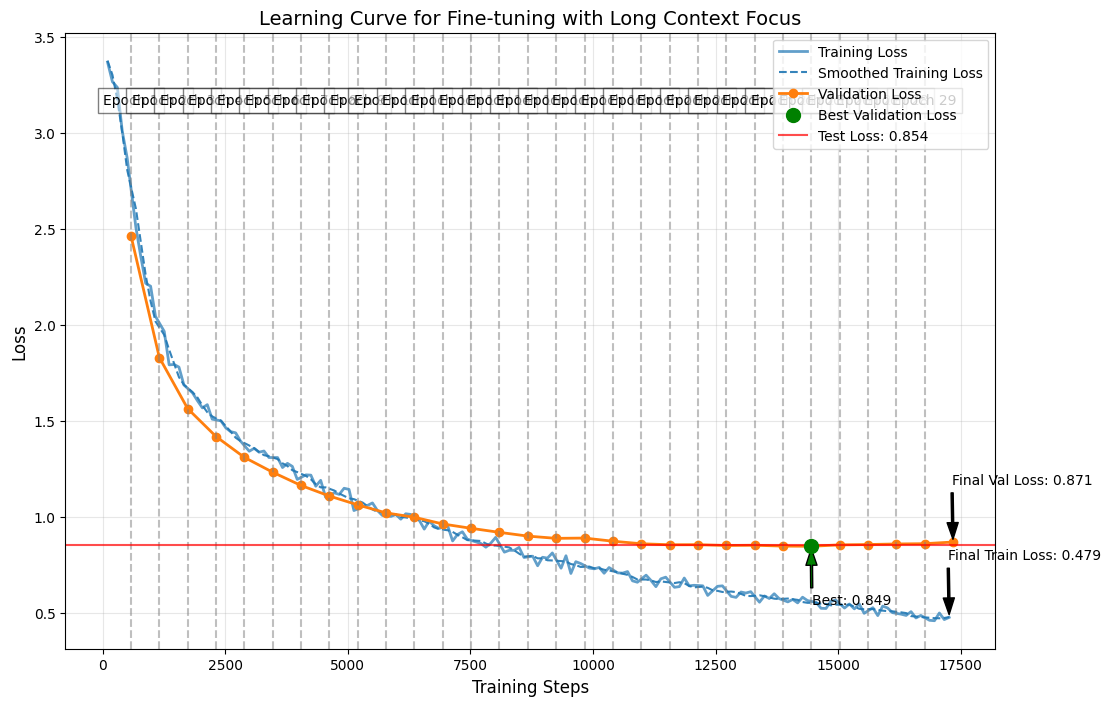

In [24]:
# Plot learning curve
plt.figure(figsize=(12, 8))

# Plot training loss
if history["train_loss"]:
    plt.plot(history["steps"], history["train_loss"], label="Training Loss", alpha=0.7, color='#1f77b4', linewidth=2)
    
    # Add smoothed trend line for training loss
    from scipy.signal import savgol_filter
    if len(history["train_loss"]) > 10:  # Need enough points for smoothing
        smoothed_train = savgol_filter(history["train_loss"], min(11, len(history["train_loss"]) // 2 * 2 + 1), 3)
        plt.plot(history["steps"], smoothed_train, '--', color='#1f77b4', alpha=0.9, linewidth=1.5, label="Smoothed Training Loss")

# Plot evaluation loss
if history["eval_loss"]:
    plt.plot(history["eval_steps"], history["eval_loss"], label="Validation Loss", marker="o", color='#ff7f0e', linewidth=2)

# Add epoch boundaries
steps_per_epoch = len(train_dataloader)
for i in range(1, NUM_EPOCHS):
    plt.axvline(x=i * steps_per_epoch, color='gray', linestyle='--', alpha=0.5)
    plt.text(i * steps_per_epoch, plt.ylim()[1] * 0.9, f"Epoch {i}", 
             horizontalalignment='center', verticalalignment='center', 
             bbox=dict(facecolor='white', alpha=0.5))

plt.xlabel("Training Steps", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Learning Curve for Fine-tuning with Long Context Focus", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Add annotations
if history["train_loss"]:
    plt.annotate(f"Final Train Loss: {history['train_loss'][-1]:.3f}", 
                xy=(history["steps"][-1], history["train_loss"][-1]),
                xytext=(history["steps"][-1]-20, history["train_loss"][-1]+0.3),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                fontsize=10)

if history["eval_loss"]:
    plt.annotate(f"Final Val Loss: {history['eval_loss'][-1]:.3f}", 
                xy=(history["eval_steps"][-1], history["eval_loss"][-1]),
                xytext=(history["eval_steps"][-1]-20, history["eval_loss"][-1]+0.3),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                fontsize=10)
    
    # Add best validation loss point
    best_idx = np.argmin(history["eval_loss"])
    plt.scatter(history["eval_steps"][best_idx], history["eval_loss"][best_idx], 
                s=100, color='green', zorder=5, label="Best Validation Loss")
    plt.annotate(f"Best: {history['eval_loss'][best_idx]:.3f}", 
                xy=(history["eval_steps"][best_idx], history["eval_loss"][best_idx]),
                xytext=(history["eval_steps"][best_idx]+10, history["eval_loss"][best_idx]-0.3),
                arrowprops=dict(facecolor='green', shrink=0.05, width=1.5, headwidth=8),
                fontsize=10)

# Add test loss
plt.axhline(y=test_loss, color='red', linestyle='-', alpha=0.7, label=f"Test Loss: {test_loss:.3f}")

# Update legend with the new entries
plt.legend(fontsize=10)

# Save plot with high resolution
plt.savefig(os.path.join(OUTPUT_DIR, "learning_curve.png"), dpi=300, bbox_inches='tight')
plt.show()

In [25]:
# Calculate key metrics from the learning curve
if history["train_loss"] and history["eval_loss"]:
    # Initial losses
    initial_train_loss = history["train_loss"][0]
    initial_eval_loss = history["eval_loss"][0]
    
    # Final losses
    final_train_loss = history["train_loss"][-1]
    final_eval_loss = history["eval_loss"][-1]
    
    # Best validation loss
    best_eval_loss = min(history["eval_loss"])
    best_epoch = history["eval_loss"].index(best_eval_loss) + 1
    
    # Improvement percentages
    train_improvement = ((initial_train_loss - final_train_loss) / initial_train_loss) * 100
    eval_improvement = ((initial_eval_loss - final_eval_loss) / initial_eval_loss) * 100
    
    # Generalization gap
    initial_gap = initial_eval_loss - initial_train_loss
    final_gap = final_eval_loss - final_train_loss
    
    print("\n=== Learning Curve Analysis ===\n")
    print(f"Initial Training Loss: {initial_train_loss:.4f}")
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Training Improvement: {train_improvement:.2f}%\n")
    
    print(f"Initial Validation Loss: {initial_eval_loss:.4f}")
    print(f"Final Validation Loss: {final_eval_loss:.4f}")
    print(f"Best Validation Loss: {best_eval_loss:.4f} (Epoch {best_epoch})")
    print(f"Validation Improvement: {eval_improvement:.2f}%\n")
    
    print(f"Initial Generalization Gap: {initial_gap:.4f}")
    print(f"Final Generalization Gap: {final_gap:.4f}\n")
    
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Perplexity: {test_perplexity:.4f}")
    
    # Save analysis to file
    analysis = {
        "initial_train_loss": initial_train_loss,
        "final_train_loss": final_train_loss,
        "train_improvement_percent": train_improvement,
        "initial_eval_loss": initial_eval_loss,
        "final_eval_loss": final_eval_loss,
        "best_eval_loss": best_eval_loss,
        "best_epoch": best_epoch,
        "eval_improvement_percent": eval_improvement,
        "initial_generalization_gap": initial_gap,
        "final_generalization_gap": final_gap,
        "test_loss": test_loss,
        "test_perplexity": test_perplexity
    }
    
    with open(os.path.join(OUTPUT_DIR, "learning_curve_analysis.json"), "w") as f:
        json.dump(analysis, f, indent=2)


=== Learning Curve Analysis ===

Initial Training Loss: 3.3685
Final Training Loss: 0.4791
Training Improvement: 85.78%

Initial Validation Loss: 2.4648
Final Validation Loss: 0.8712
Best Validation Loss: 0.8491 (Epoch 25)
Validation Improvement: 64.66%

Initial Generalization Gap: -0.9037
Final Generalization Gap: 0.3921

Test Loss: 0.8535
Test Perplexity: 2.3479
